410721242 資工四 何昀軒

In [1]:
# import module
import torch
import torch.nn as nn
from Dataset import myDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
# Parameters
num_classes = 3
num_epochs = 30
BATCH_SIZE = 64

In [3]:
# Load train and test data
trn_data = myDataset(file="train.csv", transform=transforms.ToTensor())
# split 70% data for train, 30% for validation
train_size = int(0.7 * len(trn_data))
valid_size = len(trn_data) - train_size
trn_data, valid_data = torch.utils.data.random_split(trn_data, [train_size, valid_size])
tst_data = myDataset(file="test.csv", transform=transforms.ToTensor())

trn_loader = DataLoader(dataset=trn_data, batch_size=BATCH_SIZE,shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE,shuffle=True)
tst_loader = DataLoader(dataset=tst_data, batch_size=BATCH_SIZE)

In [4]:
# Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        
        self.cnn1 = nn.Conv2d(                                      # Convolution 1 , input_shape = (1, 32, 32)
                        in_channels=1,
                        out_channels=32,
                        kernel_size=5,
                        stride=1,
                        padding=2)                                  # output_shape = (32, 32, 32)
        self.bn1 = nn.BatchNorm2d(32)                               # Batch normalization 1
        self.relu1 = nn.ReLU()                                      # activation  
        self.maxpool1 = nn.MaxPool2d(kernel_size=4)                 # Max pool 1 , output_shape = (32, 8, 8)
        self.cnn2 = nn.Conv2d(                                      # Convolution 2
                        in_channels=32,
                        out_channels=64,
                        kernel_size=5,
                        stride=1,
                        padding=2)                                  # output_shape = (64, 8, 8)
        self.bn2 = nn.BatchNorm2d(64)                               # Batch normalization 2
        self.relu2 = nn.ReLU()                                      # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=4)                 # Max pool 2 , output_shape = (64, 2, 2)  
        self.fc1 = nn.Linear(64*2*2, num_classes)                   # Fully connected 1 , input_shape = (64 * 2 * 2)
    
    def forward(self, x):
        
        x = self.cnn1(x)
        x = self.relu1(self.bn1(x))
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.relu2(self.bn2(x))                                 
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)                                   # flatten the output
        output = self.fc1(x)                                        # Linear function (readout)
        return output, x                                            # return x for visualization

In [5]:
model = CNN_Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)         # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                                   # the target label is not one-hotted

In [6]:
def fit_model(model, loss_func, optimizer, num_epochs, train_loader, test_loader):
    # Traning the Model
    training_loss = []                                              # list for store loss & acc value
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    for epoch in range(num_epochs):
        # training model & store loss & acc / epoch
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):
            
            # Forward propagation
            outputs = model(images)[0]                              # CNN model output
            train_loss = loss_func(outputs, labels)                 # calculate cross entropy loss

            # Backward
            optimizer.zero_grad()                                   # clear gradients
            train_loss.backward()                                   # backpropagation, calculate gradients

            # Gradient Step
            optimizer.step()                                        # apply gradients and update parameters

            predicted = torch.max(outputs.data, 1)[1]               # get predictions from the maximum value
            
            total_train += len(labels)                              # total number of train data labels
            correct_train += (predicted == labels).float().sum()    # total correct predictions of train data
        
        train_accuracy = 100 * correct_train / float(total_train)   # calculate & store train_acc / epoch
        training_accuracy.append(train_accuracy)
        training_loss.append(train_loss.data)                       # store loss / epoch
        # evaluate model & store loss & acc / epoch
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:

            # Forward propagation
            outputs = model(images)[0] 
            val_loss = loss_func(outputs, labels)                   # Calculate softmax and cross entropy loss
            predicted = torch.max(outputs.data, 1)[1]               # get predictions from the maximum value

            
            total_test += len(labels)                               # total number of test data labels
            correct_test += (predicted == labels).float().sum()     # total correct predictions of test data

        val_accuracy = 100 * correct_test / float(total_test)       # calculate & store val_acc / epoch
        validation_accuracy.append(val_accuracy)
        validation_loss.append(val_loss.data)                       # store val_loss / epoch

        print('Train Epoch: {}/{} Traing_Loss: {} Traing_acc: {:.6f}% Val_Loss: {} Val_accuracy: {:.6f}%'.format(epoch+1, num_epochs, train_loss.data, train_accuracy, val_loss.data, val_accuracy))
    
    return training_loss, training_accuracy, validation_loss, validation_accuracy

In [7]:
training_loss, training_accuracy, validation_loss, validation_accuracy = fit_model(model, loss_func, optimizer, num_epochs, trn_loader, valid_loader)

Train Epoch: 1/30 Traing_Loss: 0.8525720238685608 Traing_acc: 48.677250% Val_Loss: 0.9149513840675354 Val_accuracy: 56.790123%
Train Epoch: 2/30 Traing_Loss: 0.6855289936065674 Traing_acc: 72.751320% Val_Loss: 0.701896071434021 Val_accuracy: 79.629631%
Train Epoch: 3/30 Traing_Loss: 0.5556931495666504 Traing_acc: 85.449738% Val_Loss: 0.5618810653686523 Val_accuracy: 85.802467%
Train Epoch: 4/30 Traing_Loss: 0.49033257365226746 Traing_acc: 89.682541% Val_Loss: 0.5506885051727295 Val_accuracy: 88.271606%
Train Epoch: 5/30 Traing_Loss: 0.41329658031463623 Traing_acc: 91.269844% Val_Loss: 0.4608863294124603 Val_accuracy: 87.654320%
Train Epoch: 6/30 Traing_Loss: 0.3491668403148651 Traing_acc: 94.708992% Val_Loss: 0.3903864026069641 Val_accuracy: 91.358025%
Train Epoch: 7/30 Traing_Loss: 0.3104687035083771 Traing_acc: 96.031746% Val_Loss: 0.32426974177360535 Val_accuracy: 92.592590%
Train Epoch: 8/30 Traing_Loss: 0.293700635433197 Traing_acc: 96.296295% Val_Loss: 0.3107680082321167 Val_accu

In [8]:
# test the model
correct_test = 0
total_test = 0
model.eval()
with torch.no_grad():
    for img, lbl in tst_loader:
        predict = torch.max(model(img)[0], 1)[1]
        total_test += predict.size()[0]
        correct_test += (predict == lbl).float().sum()
        test_accuracy = 100 * correct_test / float(total_test)
    print('Test_accuracy: {:.6f}%'.format(test_accuracy))

Test_accuracy: 97.500000%


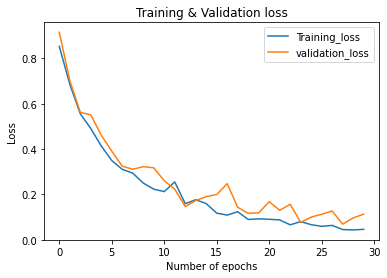

In [9]:
# visualization train & validation loss
plt.plot(range(num_epochs), training_loss, label='Training_loss')
plt.plot(range(num_epochs), validation_loss, label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

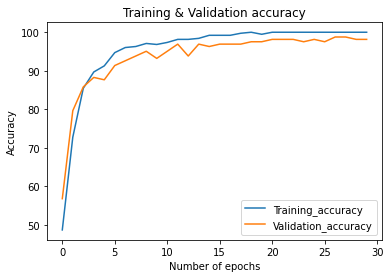

In [10]:
# visualization train & validation accuracy
plt.plot(range(num_epochs), training_accuracy, label='Training_accuracy')
plt.plot(range(num_epochs), validation_accuracy, label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()